### Time walk correction

In [1]:
import sys,time
sys.path.insert(0,'python/')
import struct
import matplotlib.pyplot as plt
import numpy.polynomial.chebyshev as cheb
import numpy as np
# import data handling class
from DT5550_Waveform import *

In [2]:
# filename = 'C:/data/20211220_154959/....'
filename = 'C:/data/20211221_150523/wa'

#### find a nice high waveform from a waveform run

In [3]:
# offset to suppress the zero bins priot to the signal
idx_offset=8

print('Open datafile:',filename)
waves = DT5550_Waveform(file=filename)
trace = []
maxfound = 0
index_max = -1
idet_max = -1
while (waves.read_event() != -1):
    idet= 0
    #print('next event')
    for idet in range(N_DETECTOR):
        idx = 0
        for i in range(200):
            #print(i,waves.analog[idet,i],waves.digital[0,idet,i])
            if waves.digital[0,idet,i] == 1:
                idx = i+10
                break
        if idx>0:
            trace.append(waves.analog[idet,idx+idx_offset:1022]-waves.config['detector_settings'][idet]['BASE'])
            if trace[-1].max() > maxfound:
                maxfound = trace[-1].max()
                index_max = len(trace)-1
                idet_max = idet

print(index_max)
#
# normalize the template to the peak of the waveform
#
template = trace[index_max]

Open datafile: C:/data/20211221_124341/waveform_20211221_124341_1.raw
7


#### Plot the highest amplitude waveform

peak = 893.0  area = 1023.33984375  gain = 1400  peak/area = 0.8726328848172535


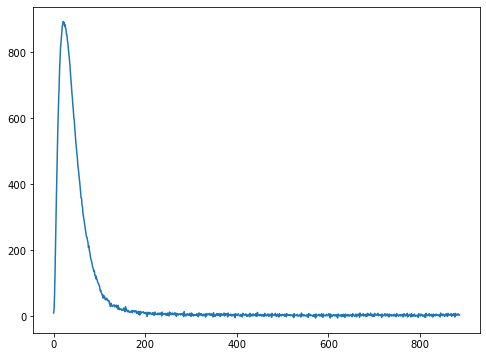

In [4]:
plt.figure(figsize=(8,6))
plt.plot(template)

inttime=waves.config['registers']['INTTIME']
gain=waves.config['detector_settings'][idet_max]['GAIN']

peak = template.max()
area = template[0:inttime].sum()/2**16*gain
print('peak =',peak,' area =',area,' gain =',gain,' peak/area =',peak/area)
area_to_peak = peak/area

#### Make template & fit

Make a timewalk correction template from the waveform found above.
- plot the time versus $\alpha \equiv V_{th}/V_{pk}$. The correction factor $\alpha$ uniquely sets the timewalk for all pulses we observe. This goes under the assumption that the shape of all pulses from a NaI crystal are identical.
- Note that $0\leq\alpha<1$ by construction, since $V_{th}\leq V_{pk}$ or else no trigger would have fired.
- Fit a Chebyshev polynomial to get the corrections
- If the fit does not look good, because the initial slope is too steep, then consider changing the idx_offset above

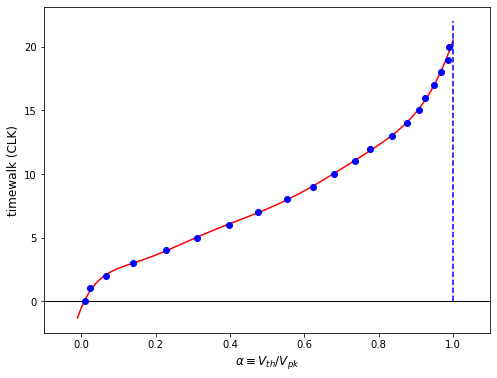

In [5]:

#
# we only need the rising edge of our signal to make a correction 
#
template_fit = template/template.max()
idx = template_fit.argmax()
template_fit = template_fit[0:idx]
clock_bins = np.arange(0,len(template_fit),1)

#
# plot the template
#
plt.figure(figsize=(8,6))
xplot = np.linspace(-0.01,1,100)
#
# fit a chebyshev polynomoial
#
chebyshev_order = 8
fitpar = cheb.chebfit(template_fit,clock_bins,chebyshev_order)
#
#
#
vals = cheb.chebval(xplot, fitpar)
plt.plot(xplot, vals, 'r-')
plt.plot(template_fit,clock_bins,'o',color='blue')
plt.hlines(0,-1,2,linewidth=1,color='black')
plt.plot([1,1],[0,22],'--',color='blue')
plt.xlim(-0.1,1.1)
plt.xlabel('$\\alpha \equiv V_{th}/V_{pk}$',fontsize=12)
plt.ylabel('timewalk (CLK)',fontsize=12)
plt.show()
#plt.ylim([-0.1,1.1])

#### Write calibration to json file

In [6]:
tw_dict = {"timewalk": {"area_to_peak": area_to_peak,
                        "chebyshev_order": chebyshev_order,
                        "chebyshev_parameters": fitpar.tolist()}}
print(tw_dict)
waves.config.update(tw_dict)
print('open config:',waves.config_file)
fout = open(waves.config_file,"w")
json.dump(waves.config,fout,indent=4)
fout.close()

{'timewalk': {'area_to_peak': 0.8726328848172535, 'chebyshev_order': 8, 'chebyshev_parameters': [-11518.231669555353, 21213.116451455247, -16460.952455666975, 10689.34403729851, -5697.254968091369, 2417.8489009306363, -771.7959322429689, 166.2784670391227, -17.80923192384891]}}
open config: C:/data/20211221_124341\config_20211221_124341.json


In [11]:
1/0.38


2.6315789473684212